# Evaluation of the model

In [1]:
import os
import csv
import pickle
import numpy as np
from scipy.io import loadmat, savemat
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import random
from tqdm import tqdm
import datetime
import scipy.stats as sp 
from matplotlib import cm
import imageio
import pandas as pd
from scipy.stats import ttest_ind,  shapiro, mannwhitneyu, pearsonr
import seaborn as sb

In [2]:
log_dir = "./log" 
FIGSIZE = (15,9)
LW = 3
Nobj = 3
plt.rcParams.update({'font.size': 10})

In [3]:
def plot_performance(means,stds,X=None,names=None,title="",ylabel="performance", minimum = -np.inf, maximum=np.inf,
                     log=False, double =False, xlabel="learning episodes"):
    if names is None:
        names = [str(j) for j in range(len(means))]
    compute_X = (X is None)
    if len(means)<6:
        ncol = [1,1,2,2,3][len(means)-1] 
    else:
        ncol = len(means)//2
    fig, ax = plt.subplots(figsize=FIGSIZE)
    colors = ['blueviolet','royalblue','crimson','darkgreen','orange']
    handles = []
    for i in range(len(means)):
        if (double and i>=len(means)/2):
            linestyle = ":"
            color = colors[i%(len(means)//2)]
        else:
            linestyle = "-"
            color = colors[i%len(colors)]
        
        mean, std = np.array(means[i]), np.array(stds[i])
        mean_p_std = np.minimum(mean+std, maximum)
        mean_m_std = np.maximum(mean-std, minimum)
        
        if compute_X:
            X = [x for x in range(len(mean))]
        plt.plot(X,mean, color = color,lw=LW, linestyle=linestyle)
        ax.fill_between(X,mean_p_std , mean_m_std, color= color, alpha=0.15)
        plt.plot(X, mean_p_std, color=color, alpha=0.2)
        plt.plot(X, mean_m_std, color=color, alpha=0.2)
        handles.append( mlines.Line2D([], [], color = color, linestyle=linestyle, label= names[i]))
    if log:
        plt.yscale("log")
        if (X[1]-X[0])!=(X[-1]-X[-2]):
            plt.xscale("log")
    else:
        if minimum != -np.inf and maximum!=np.inf:
            plt.ylim(minimum,maximum)
        elif minimum != -np.inf:
            plt.ylim(minimum)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(handles=handles, numpoints = 2,ncol=1,bbox_to_anchor=(1.01, 1.))
    plt.show()

## One model Many runs

In [4]:
def compute_performance(subdirs, full=False, plot=False):
    if full:
        groups = [[0,1,3],[4],[6,7,8,9],[26,14,27], [16] , [18,19,20,21], [5],[10,11,12,13], [28,15,29], [17], [22, 23,24,25]]
        groups_colors = ['grey',[0.98, 0.83, 0.37], [0.92, 0.71, 0.039], [0.90, 0.56, 0.05],[0.92, 0.28, 0.28], 'red',
                    [0.59, 0.74, 0.93] ,[0.28, 0.58, 0.92]  , [0.054, 0.30, 0.68], 'blue',  'navy' ]
        group_legend = ['Hand', 'Grasp Stick1','Move Stick1', 'Bring Stick1 Closer to Magnet', 'Grasp Magnet', 'Move Magnet',  
                        'Grasp Stick2','Move Stick2', 'Bring Stick2 Closer to Scratch', 'Grasp Scratch','Move Scratch']
    elif Nobj == 5:
        groups = [[0,1,3],[4, 6,7,8,9, 26,14,27] ,[5,10,11,12,13,28,15,29],[16,18,19,20,21], [17,22, 23,24,25]]
        groups_colors = ['blueviolet', 'royalblue','crimson','darkgreen','orange']
        group_legend = ['Hand', 'Left Stick', 'Right Stick', 'Magnet', 'Scratch']
    else:
        groups = [[0,1,3],[4, 6,7,8,9, 26,14,27,5,10,11,12,13,28,15,29],[16,18,19,20,21,17,22, 23,24,25]]
        groups_colors = ['darkgreen', 'orange', 'crimson']
        group_legend = ['Easy', 'Medium', 'Hard']

    perf = []
    for subdir in subdirs:
        data = pd.read_csv(subdir+'/progress.csv')
        n_points = data['test/success_goal_0'].shape[0]
        nb_groups = len(groups)
        nb_instr = 30
        episodes = data['train/episode']/1000
        
        task_success_rates = np.zeros([n_points, nb_instr])
        for i in range(nb_instr):
            task_success_rates[:, i] = data['test/success_goal_' + str(i)]
        zero_success_rates = task_success_rates.copy()
        for i in range(zero_success_rates.shape[0]):
            for j in range(zero_success_rates.shape[1]):
                if np.isnan(zero_success_rates[i, j]):
                    zero_success_rates[i, j] = 0

        group_task_success_rates = np.zeros([n_points, nb_groups])
        for i in range(nb_groups):
            group_task_success_rates[:, i] = zero_success_rates[:, groups[i]].mean(axis=1)
        if len(group_task_success_rates) == 100:
            perf.append(group_task_success_rates[[it*10 for it in range(10)]])
        else:
            perf.append(group_task_success_rates)
        
    perf_mean = np.mean(perf, axis=0)
    perf_std = np.std(perf, axis=0)

    if plot:
        fig = plt.figure(figsize=(22, 15), frameon=False)
        ax = fig.add_subplot(111)
        ax.spines['top'].set_linewidth(6)
        ax.spines['right'].set_linewidth(6)
        ax.spines['bottom'].set_linewidth(6)
        ax.spines['left'].set_linewidth(6)
        ax.tick_params(width=4, direction='in', length=10, labelsize='small')

        for i in range(nb_groups):
            plt.plot(episodes, perf_mean[:, i], linewidth=10, c=groups_colors[i])
            plt.fill_between(episodes, perf_mean[:, i],perf_mean[:, i]+perf_std[:,i],color=groups_colors[i], alpha=0.15)
            plt.fill_between(episodes, perf_mean[:, i],perf_mean[:, i]-perf_std[:,i],color=groups_colors[i], alpha=0.15)
            
            
        lab = plt.xlabel('Episodes (x$10^3$)')
        plt.ylim([-0.01, 1.01])
        plt.yticks([0.25, 0.50, 0.75, 1])
        lab2 = plt.ylabel('Competence')
        plt.title("Performance")
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width, box.height * 0.8])
        leg = ax.legend(group_legend, loc='lower left', bbox_to_anchor=(0.0, 1.01), ncol=2,
                        borderaxespad=0, frameon=False, prop={'size': 30})
    return perf

In [5]:
def confusion_matrix(subdirs, data_type, iterations, n_cpus=None, plot=True):
    def analyze_confusion_matrix(conf_matrix):
        [[TN,FP],[FN,TP]] = conf_matrix
        TPR = TP/(TP+FN) if (TP +FN) !=0 else 0
        TNR = TN/(TN+FP) if (FP +TN) !=0 else 0
        ACC = (TP+TN)/(TP+TN+FP+FN) if (TP+TN+FP+FN) !=0 else 0
        Precision = TP/(TP+FP) if (TP+FP) !=0 else 0
        FS = 2*TP/(2*TP+FP+FN) if (2*TP+FP+FN) !=0 else 0
        return [TPR,TNR,ACC,Precision,FS]
    if Nobj == 5:
        tasks_group =[[0,1,3],
                      [4,6,7,8,9,26,14,27] , 
                      [5,10,11,12,13,28,15,29], 
                      [16,18,19,20,21],
                      [17,22, 23,24,25]]
    else:
        tasks_group =[[0,1,3],[4,6,7,8,9,26,14,27, 5,10,11,12,13,28,15,29],[16,18,19,20,21, 17,22, 23,24,25]]

    group_legend = ['Hand', 'Left Stick','Right Stick','Magnet', 'Scratch']
    color = ['blueviolet','royalblue','crimson','darkgreen','orange']
    
    rates_names = ['Recall','True Negative Rate','Accuracy','Precision','F1 Score']
    
    Null_F1,p = [], None
    Rates = []
    Rates_error = []
    cf = []
    F1score = []
    for it in range(iterations):      
        rates_mean = []
        test = []
        for model in subdirs:
            if data_type == 1:
                for cpu in range(n_cpus):
                    filename = 'confusion_matrix_r'+str(cpu)+'_'+str(it)+'.pk'
                    with open(model+'/'+filename,'br')as f:
                        conf_matrix = pickle.load(f)
                        if p is None:
                            cong_matrix= np.array(conf_matrix)
                            p = ((conf_matrix[:,1,0]+conf_matrix[:,1,1])/1000)
                    rates = [[] for _ in range(5)]
                    for group in tasks_group:
                        res = analyze_confusion_matrix(np.mean(conf_matrix[group],axis=0))
                        for i in range(5):
                            rates[i].append(res[i])
                    rates_mean.append(rates)
            else:
                filename = 'confusion_matrix_evaluation_data_'+str(it)+'.pk'
                with open(model+'/'+filename,'br')as f:
                    conf_matrix = pickle.load(f)
                for b in range(len(conf_matrix)):
                    rates = [[] for _ in range(5)]
                    for group in tasks_group:
                        res = analyze_confusion_matrix(np.mean(conf_matrix[b][group],axis=0))
                        for i in range(5):
                            rates[i].append(res[i])
                    rates_mean.append(rates)
        F1score.append(np.array(rates_mean)[:,4])
        Rates.append(np.mean(rates_mean, axis=0))
        Rates_error.append(np.std(rates_mean, axis=0))
    
    Rates = np.array(Rates)
    Rates_error = np.array( Rates_error)
    F1score_mean = Rates[:,4]
    F1score_std = Rates_error[:,4]
    
    for group in tasks_group:
        Null_F1.append(np.mean(p[group]))
        
    
    if plot:
        for rate in range(5):
            fig,ax = plt.subplots(1,1, sharex=True,figsize=(16,9))

            X = range(iterations)
            for g in range(5):
                mean_p_std = np.minimum(Rates[:,rate,g]+Rates_error[:,rate,g], 1)
                mean_m_std = np.maximum(Rates[:,rate,g]-Rates_error[:,rate,g], 0)
                plt.plot(Rates[:,rate,g], c=color[g], label=group_legend[g])
                ax.fill_between(X,mean_p_std, mean_m_std, color= color[g], alpha=0.15)
            plt.title(rates_names[rate])
            plt.legend()
            plt.ylim((0,1))

        plot_performance(np.swapaxes(F1score_mean,0,1) , np.swapaxes(F1score_std,0,1), minimum=0, maximum=1, title="Rewards prediction", 
                        ylabel="F1 Score", xlabel="iterations")
    return  np.swapaxes(F1score, 0,1), Null_F1

### ATT not random

In [6]:
if Nobj ==5:
    def regroup(data, func=np.mean):
        if len(np.shape(data)) == 3: 
            """ data = [params, iterations, obs_dim=18] """
            hand = func(data[:,:,:6], axis=2)
            lstick = func(data[:,:,6:10], axis=2)
            rstick = func(data[:,:,10:14], axis=2)
            magnet = func(data[:,:,14:16], axis=2)
            scratch = func(data[:,:,16:18], axis=2)
        else:
            hand = func(data[:6])
            lstick = func(data[6:10])
            rstick = func(data[10:14])
            magnet = func(data[14:16])
            scratch = func(data[16:18])
        return np.array([hand, lstick, rstick, magnet, scratch])
else:
    def regroup(data, func=np.mean):
        if len(np.shape(data)) == 3: 
            """ data = [params, iterations, obs_dim=18] """
            easy = func(data[:,:,:6], axis=2)
            medium = func(data[:,:,6:14], axis=2)
            hard = func(data[:,:,14:18], axis=2)
        else:
            easy = func(data[:6])
            medium = func(data[6:14])
            hard = func(data[14:18])
        return np.array([easy, medium, hard])

def prediction_errors(subdirs,func,data_type, iterations, n_cpus=None, plot=True):
    with open("/home/tim/Documents/stage-m2/tf_test/data/ArmToolsToyR_eval.pk", 'br') as f:
        [true_traj,_] = pickle.load(f)
    true_traj = true_traj[:,:,:18]
    # compute null model
    null_model_traj = np.mean(true_traj, axis=(0))
    N_traj = np.sum((null_model_traj-true_traj)**2, axis=(0,1))
    null_error_traj = func(regroup(null_model_traj-true_traj, np.linalg.norm),axis=(1,2))
    
    true_traj = np.swapaxes(true_traj, 0,1)
    
    null_model_trans = np.mean(true_traj, axis=(0,1))
    N_trans = np.sum((null_model_trans-true_traj)**2, axis=(0,1))
    null_error_trans = func(regroup(null_model_trans-true_traj, np.linalg.norm),axis=(1,2))
    
    if subdirs is None:
        return [null_error_traj,null_error_trans]
    
    objects = ['Hand', 'Left Stick','Right Stick','Magnet', 'Scratch']
    
    traj_means, trans_means = [], []
    traj_stds, trans_stds = [], []
    R_traj_means, R_trans_means = [], []
    R_traj_stds, R_trans_stds = [], []
    Traj, Trans, R_Traj, R_Trans = [], [], [], []
    
    for it in range(iterations):
        traj_errors, trans_errors, R_trans, R_traj = [], [], [], []
        for subdir in subdirs:
            for cpu in range(n_cpus):
                data = 'prediction_r'+str(cpu)+'_'+str(it)+'.pk'
                with open(subdir+'/'+data,'br')as f:
                    (traj,trans) = pickle.load(f)
                traj = traj[:,:,:18]
                E_trans = np.sum((trans-true_traj)**2, axis=(0,1))
                E_traj = np.sum((traj-true_traj)**2, axis=(0,1))
                R_trans.append(1-E_trans/N_trans)
                R_traj.append(1-E_traj/N_traj)  
                trans_errors.append(func(regroup(trans-true_traj, np.linalg.norm),axis=(1,2)))
                traj_errors.append(func(regroup(traj-true_traj, np.linalg.norm),axis=(1,2)))


        Traj.append(traj_errors.copy())
        Trans.append(trans_errors.copy())
        R_Traj.append(R_traj.copy())
        R_Trans.append(R_trans.copy())
        
        if plot:
            traj_means.append(np.mean(traj_errors, axis=0))
            trans_means.append(np.mean(trans_errors, axis=0))
            trans_stds.append(np.std(trans_errors, axis=0))
            traj_stds.append(np.std(traj_errors, axis=0))
            
            R_traj_means.append(np.mean(R_traj, axis=0))
            R_trans_means.append(np.mean(R_trans, axis=0))
            R_trans_stds.append(np.std(R_trans, axis=0))
            R_traj_stds.append(np.std(R_traj, axis=0))

    names = ['trajectory error',' transition error']
    if plot:
        pred_means = regroup(np.array([traj_means]+[trans_means]))
        pred_stds =  regroup(np.array([traj_stds]+[trans_stds]))
        for obj in range(5):
            plot_performance(pred_means[obj], pred_stds[obj],names=names, minimum=0, title="Error "+objects[obj], 
                         ylabel="Trajectory prediction error",xlabel="Iterations", log=True)
    

    if plot:
        R_means = regroup(np.array([R_traj_means]+[R_trans_means]))
        R_stds = regroup(np.array([R_traj_stds] +[R_trans_stds]))
        names = ['trajectory R²','transition R²']
        for obj in range(5):
            plot_performance(R_means[obj], R_stds[obj],names=names, minimum=0, maximum=1, 
                             ylabel="R²",xlabel="Iterations", title="R² "+objects[obj])
    return (np.swapaxes(Traj,0,1), np.swapaxes(Trans,0,1),np.swapaxes(R_Traj,0,1),np.swapaxes(R_Trans,0,1))

In [7]:
def episodes_prediction_errors(subdirs,func,data_type, iterations, n_cpus=None, plot=True):
    with open("/home/tim/Documents/stage-m2/tf_test/data/ArmToolsToyR_eval.pk", 'br') as f:
        [true_traj,_] = pickle.load(f)
    true_traj = true_traj[:,:,:18]
    true_traj = np.swapaxes(true_traj, 0,1)
   

    objects = ['Hand', 'Left Stick','Right Stick','Magnet', 'Scratch']
    
    traj_means, trans_means = [], []
    traj_stds, trans_stds = [], []
    Traj, Trans = [], [],
    
    it = 9
    traj_errors, trans_errors, R_trans, R_traj = [], [], [], []
    for subdir in subdirs:
        print(subdir)
        for cpu in range(n_cpus):
            data = 'prediction_r'+str(cpu)+'_'+str(it)+'.pk'
            with open(subdir+'/'+data,'br')as f:
                (traj,trans) = pickle.load(f)
            traj = traj[:,:,:18]
            trans_errors.append(func(regroup(trans-true_traj, np.linalg.norm),axis=(1)))
            traj_errors.append(func(regroup(traj-true_traj, np.linalg.norm),axis=(1)))

    Traj = traj_errors.copy()
    Trans = trans_errors.copy()
  
    return (np.swapaxes(Traj,0,1), np.swapaxes(Trans,0,1))

In [77]:
def compute_bins(obs, objx, objy, bounds):
    n_bins = [20,20]
    N_bins = n_bins[0]*n_bins[1]
    x , y = obs[:,objx], obs[:,objy]
    bins = sp.binned_statistic_2d(x, y, None, 'count', bins=n_bins, range=bounds).binnumber
    return len(set(bins))/N_bins 

objects_param = [(3,4,[[-1., 1.], [-1., 1.]]), (8,9,[[-1.5, 1.5], [-1.5, 1.5]]), 
    (12,13,[[-1.5, 1.5], [-1.5, 1.5]]), (14,15,[[-1.5, 1.5], [-1.5, 1.5]]),(16,17,[[-1.5, 1.5], [-1.5, 1.5]])]

def plt_2_rgb(ax):
    ax.figure.canvas.draw()
    data = np.frombuffer(ax.figure.canvas.tostring_rgb(), dtype=np.uint8)
    data = data.reshape(ax.figure.canvas.get_width_height()[::-1] + (3,))
    return data

def plot_coverage(subdirs, data_type, iterations, n_cpus=None ):
    subdir = subdirs[0]
    images = []
    observations = np.zeros((0,18))
    for iteration in range(iterations):

        if data_type == 1:
            for cpu in range(n_cpus):
                filename = 'final_observations_r'+str(cpu)+'_'+str(iteration)+'.pk'
                with open(subdir+"/"+filename, 'br') as f:
                    observation = pickle.load(f)
                observations = np.concatenate((observations,observation))
        else:
            observations = np.zeros((0,18))
            filename = 'final_observations_'+str(iteration)+'.pk'
            with open(subdir+"/"+filename, 'br') as f:
                observation = pickle.load(f)
            observations = np.concatenate((observations,observation))
        
        fig,ax = plt.subplots(1,1, sharex=True,figsize=(14,14))
        colors = ['blueviolet','royalblue','crimson','darkgreen','orange']
        plt.scatter(observations[:,3],observations[:,4], c=colors[0], label = "Hand")
        plt.scatter(observations[:,8],observations[:,9], c=colors[1], label = "Left Stick")
        plt.scatter(observations[:,12],observations[:,13], c=colors[2], label = "Right Stick")
        plt.scatter(observations[:,14],observations[:,15], c=colors[3], label = "Magnet")
        plt.scatter(observations[:,16],observations[:,17], c=colors[4], label = "Scratch")
        plt.legend(loc=4)
        plt.ylim((-1.51,1.51))
        plt.xlim((-1.51,1.51))
        plt.title("Coverage "+str(iteration))
        images.append(plt_2_rgb(ax))
        plt.close()
    imageio.mimsave(subdir+'/coverage.gif', images, duration=0.5)
    
def compute_coverage(subdirs, data_type, iterations, n_cpus=None, plot=True ):
    Coverage = []
    for subdir in subdirs:
        for cpu in range(n_cpus):
            coverage = [[] for _ in range(Nobj)]
            observation = np.zeros((0,18))
            for iteration in range(iterations):
                filename = 'final_observations_r'+str(cpu)+'_'+str(iteration)+'.pk'
                with open(subdir+"/"+filename, 'br') as f:
                    observation = np.concatenate((observation, pickle.load(f)))
                if Nobj == 5:
                    for obj in range(5):
                        objx, objy, bounds = objects_param[obj]
                        coverage[obj].append(compute_bins(observation, objx, objy, bounds))
                else:
                    objx, objy, bounds = objects_param[0]
                    coverage[0].append(compute_bins(observation, objx, objy, bounds))
                    objx1, objy1, bounds1 = objects_param[1]
                    b1 = compute_bins(observation, objx1, objy1, bounds1)
                    objx2, objy2, bounds2 = objects_param[2]
                    b2 = compute_bins(observation, objx2, objy2, bounds2)
                    coverage[1].append(np.mean([b1,b2],axis=0))
                    objx1, objy1, bounds1 = objects_param[3]
                    b1 = compute_bins(observation, objx1, objy1, bounds1)
                    objx2, objy2, bounds2 = objects_param[4]
                    b2 = compute_bins(observation, objx2, objy2, bounds2)
                    coverage[2].append(np.mean([b1,b2],axis=0))

            Coverage.append(np.swapaxes(coverage.copy(),0,1))
    return Coverage

In [183]:
path = "/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/"
# Random
random = [0,1,2,3,4,5,6,7,8,9]
# GRBF
grbf = [0,1,2,3,4,5,6,7,8,9]
#IMGEP
imgep = [0,1,2,3,4,5,6,7,8,9]
#EXPLO
explo = [0,1,2,3,4,5,6,7,8,9]
# Model_Free
model_free = [0]
# RL
rl = [0,1,2,3,4,6,7,8,9]

subdirs =[[path+"random_"+str(i) for i in random],
          [path+"grbf_"+str(i) for i in grbf],
          [path+"imgep_"+str(i) for i in imgep],
          [path+"explo_"+str(i) for i in explo],
          [path+"rl_"+str(i) for i in rl]
          ]


perf_subdirs=[[path+"random_"+str(i) for i in random],
              [path+"grbf_"+str(i) for i in [0,1,2,3,4,5,6,7,8]],
              [path+"imgep_"+str(i) for i in imgep],
              [path+"explo_"+str(i) for i in explo],
              [path+"rl_"+str(i) for i in rl],
              [path+"model-free_"+str(i) for i in [0]]
              ]

test = ["/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/11000"]

data_type = 1
cpus = 20
iterations = 10

subdirs = subdirs[4]

In [184]:
_ = compute_performance(test, plot=True, full=False)

EmptyDataError: No columns to parse from file

In [157]:
data = compute_coverage(subdirs,data_type, iterations=iterations, n_cpus=cpus)

0
1
2
3
4
5
6
7
8
9


In [158]:
np.shape(data)

(40, 10, 3)

In [102]:
traj, trans = episodes_prediction_errors(subdirs,np.mean,data_type,iterations=iterations, n_cpus=cpus, plot=False)

/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/rl_0


In [17]:
def plot_episodes_errors(data, log =False, ylim=False, has_legend=[0]):
    """ data [params, runs, iterations, objects] """
    fig,ax = plt.subplots(5,1, sharex=True,figsize=(16,10))
    #data = np.swapaxes(data, 1,2)
    objects = ['Hand', 'Left Stick','Right Stick', 'Magnet', 'Scratch']
    group_legend = [  obj+"\n PE" for obj in objects]
    colors = ['royalblue','crimson','darkgreen','orange','blueviolet','grey','black']
    style = ['-','--',':',';']
    
    for obj in range(5):
        plt.subplot(511+obj)

        hist, bins, _ = plt.hist(data[obj,0], 100)
      #  logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
      #  _ = plt.hist(x, bins=logbins  , stacked=True)
        #plt.xscale("log")
        #plt.yscale('log')

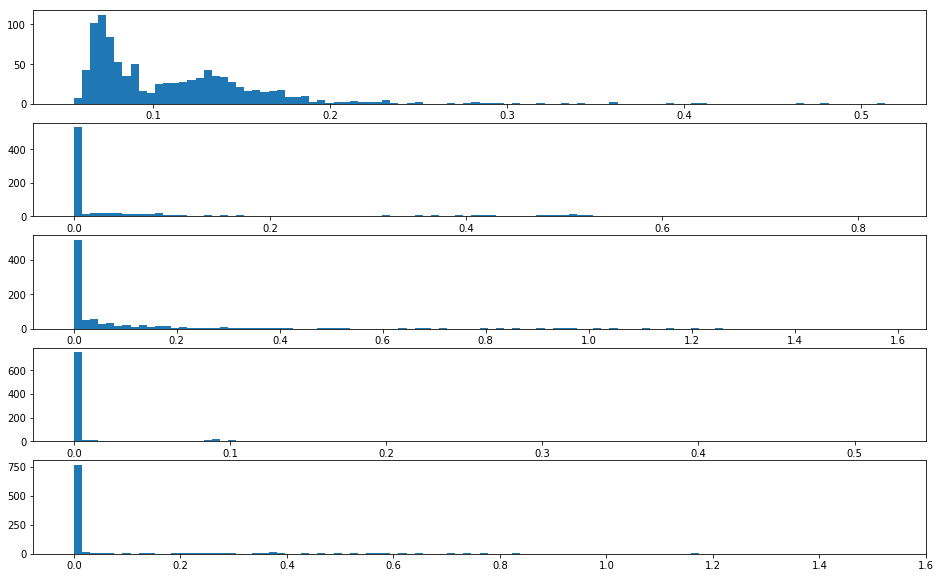

In [18]:
plot_episodes_errors(trans)

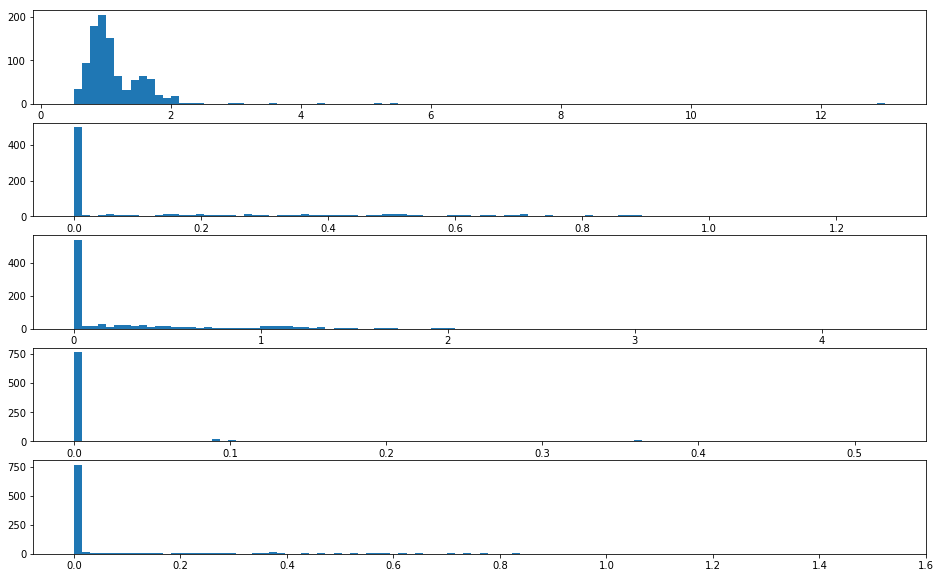

In [19]:
plot_episodes_errors(traj)

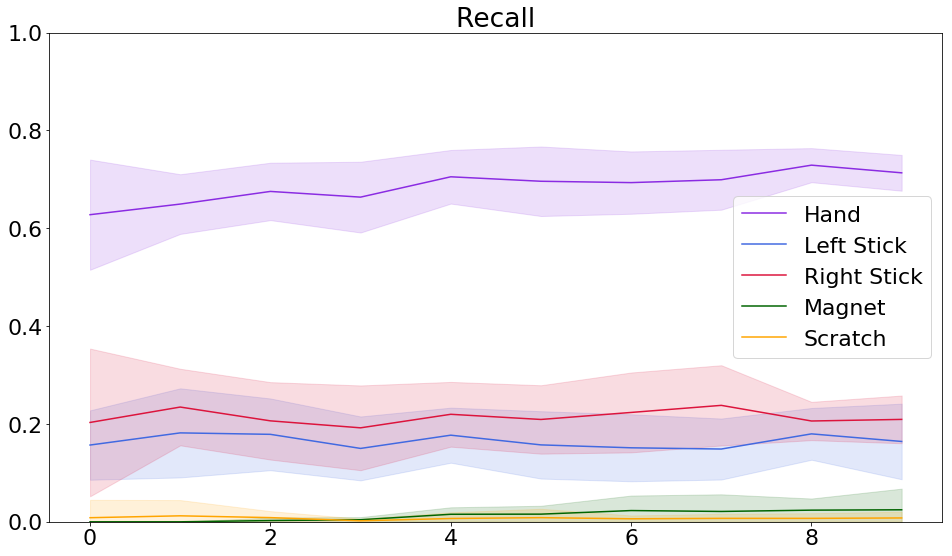

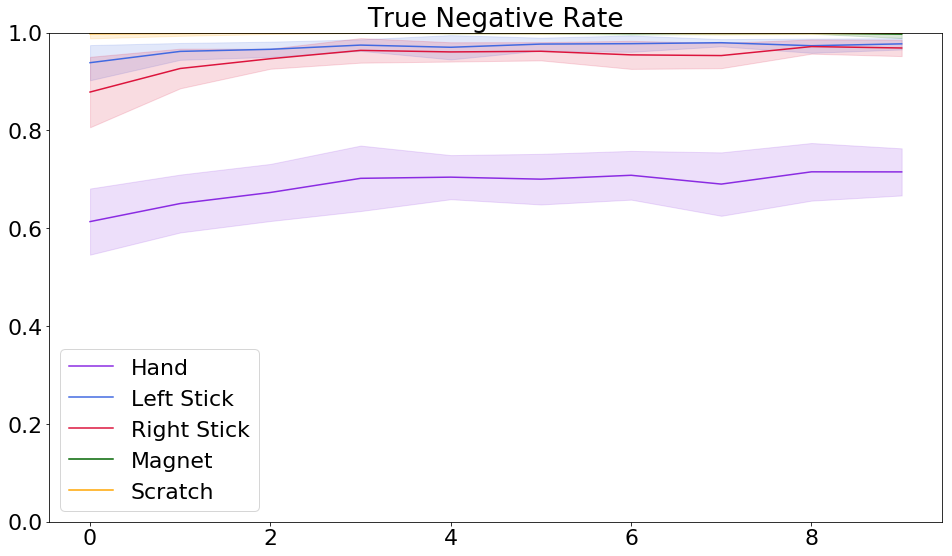

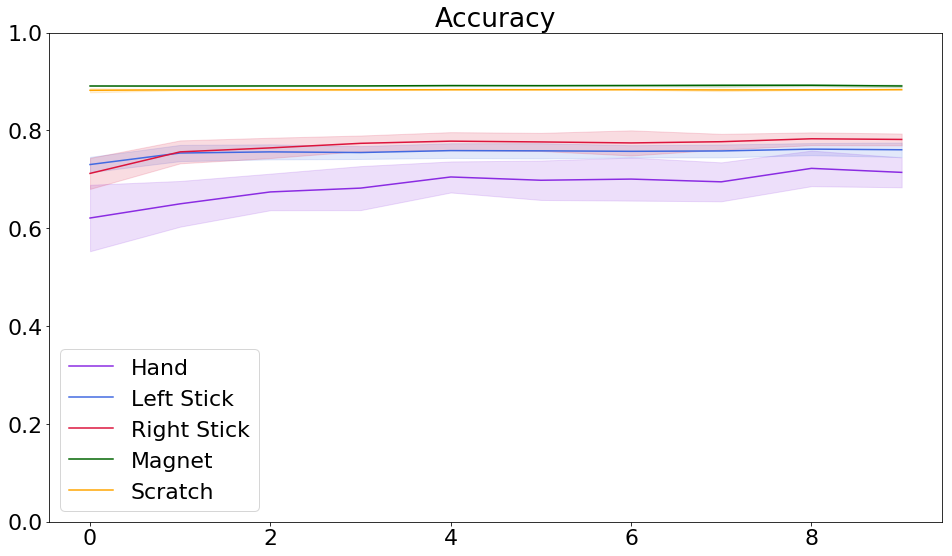

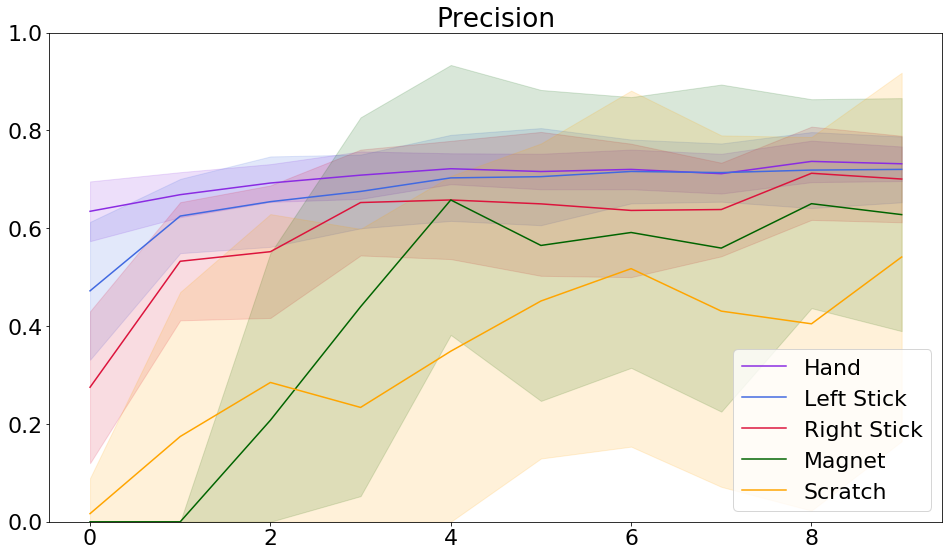

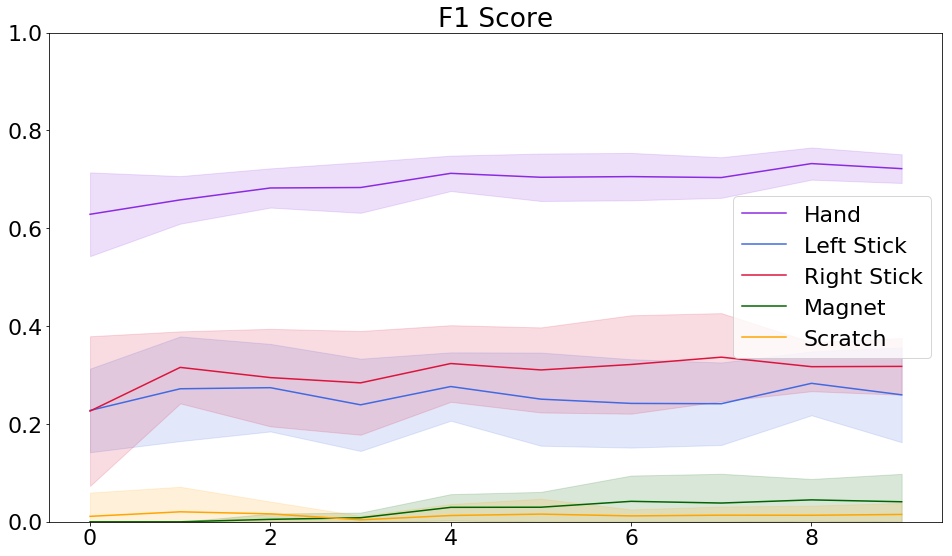

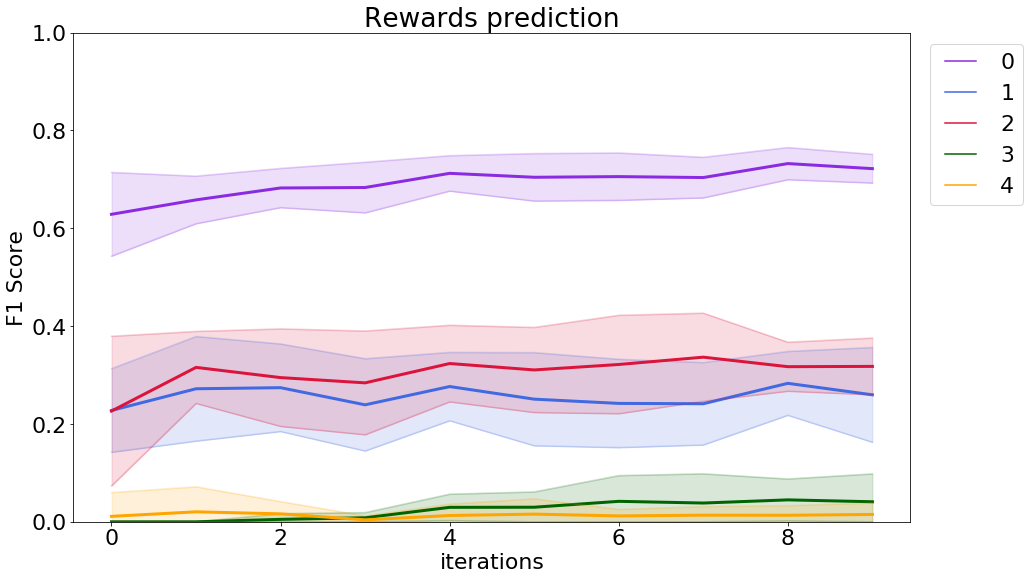

In [195]:
_, _, cf = confusion_matrix(subdirs, data_type=data_type, iterations=iterations, n_cpus=cpus)

In [268]:
plot_coverage(subdirs, data_type, iterations=iterations, n_cpus=cpus)

In [278]:
np.shape(data)

(20, 10, 5)

# Comparison params

In [13]:
def plot_objects(data, iterations, title, ylabel, minimum=0, maximum=np.inf, null_data=None,
                 log =False, ylim=False, has_legend=[0]):
    """ data [params, runs, iterations, objects] """
    fig,ax = plt.subplots(3,1, sharex=True,figsize=(8,10))
    
    objects = ['Hand', 'Left Stick','Right Stick', 'Magnet', 'Scratch']
    objects = ['Easy', 'Medium', 'Hard']
    
    colors = ['royalblue','crimson','darkgreen','orange','blueviolet','grey']
    group_legend = [  obj+"\n"+ title for obj in objects]
    style = ['-','--',':',';']
    LW = 3
    
    for obj in range(3):
        plt.subplot(311+obj)
        if not null_data is None:
            plt.plot([1,iterations],[null_data[obj] for _ in range(2)],lw=LW, c='grey', label="Null model")
        for i in range(len(data)):
            mean = np.mean(data[i],axis=0)
            std = np.std(data[i], axis=0)
            #median = np.median(data[i],axis=0)
            if len(mean) != iterations:
                X = np.array(range(len(mean))) / 10
            else:
                X = range(1,iterations+1)
            color = colors[i]

            mean_p_std = np.minimum(mean[:,obj]+std[:,obj], maximum)
            mean_m_std = np.maximum(mean[:,obj]-std[:,obj], minimum)
            if obj in has_legend:
                plt.plot(X, mean[:,obj], c=color, lw=LW, label=Names[i])
            else:
                plt.plot(X, mean[:,obj], c=color, lw=LW)
            #plt.plot(X, median[:,obj], c=color, ls='--', lw=5,label=Names[i])
            plt.fill_between(X, mean_p_std, mean_m_std, color=color, alpha=0.15)
            #plt.title(group_legend[obj])
            if obj in has_legend:
                plt.legend()
            if log:
                plt.yscale('log')
            if ylim:
                plt.ylim((0,1))
            plt.ylabel(group_legend[obj])
            if obj == 4:
                plt.xlabel("Training episodes (x10²) per model")
            s = 1 if len(data) == 5 else 0
            plt.xticks(range(s,11), [str(5*i) for i in range(s,11)])
        name = title
        plt.savefig("/home/tim/Documents/figs/comparison_data/"+name+".svg", format='svg')

### ATT random

In [252]:
path = "/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/"
# Random
random = [0,1,2,3,4,5,6,7,8,9]
# GRBF
grbf =   [0,1,2,3,4,5,6,7,8,9]
#IMGEP
imgep =  [0,1,2,3,4,5,6,7,8,9]
#EXPLO
explo =  [0,1,2,3,4,5,6,7,8,9]
# Model_Free
model_free = [0,1,2,3,4]
# RL
rl = [0,1,2,3,4,5,6,7,8,9]
# rematch RL
rematch_rl = [5,6,7,8,9]
#rematch imgep 
rematch_imgep = [0,1,2,3,4]

subdirs =[[path+"random_"+str(i) for i in random],
          [path+"grbf_"+str(i) for i in grbf],
          [path+"imgep_"+str(i) for i in imgep],
          [path+"explo_"+str(i) for i in explo],
          [path+"rl_"+str(i) for i in rl],
          [path+"rematch_imgep_"+str(i) for i in rematch_imgep],
          ]


perf_subdirs = [[path+"random_"+str(i) for i in random],
              [path+"grbf_"+str(i) for i in grbf],
              [path+"imgep_"+str(i) for i in imgep],
              [path+"explo_"+str(i) for i in explo],
              [path+"rl_"+str(i) for i in rl],
              [path+"model-free_"+str(i) for i in model_free],
              ]

rematch_perf_subdirs = [  [path+"imgep_"+str(i) for i in imgep],
                        [path+"rematch_imgep_"+str(i) for i in rematch_imgep],
                  [path+"rl_"+str(i) for i in rl],
                  [path+"rematch_rl_"+str(i) for i in rematch_rl],
                  
              ]

data_type = 1
cpus = 20

Names_5 = ['Random', 'GRBF', 'IMGEP', "EU", "//RL"]
Names_perf = ['Random', 'GRBF', 'IMGEP', "EU", "//RL",  "MFRL"]
Names_6 = ['Random', 'GRBF', 'IMGEP', "EU", "//RL", "//IMGEP"]
Names_rematch_perf = ['IMGEP', "//IMGEP", "//RL", "RL",]

iterations = 10


## Reward

In [188]:
F1 = []
for param in subdirs:
    print(param)
    F1.append(confusion_matrix(param, data_type=data_type, iterations=iterations, n_cpus=cpus, plot=False))
F1 = np.array(F1)

['/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/random_0', '/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/random_1', '/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/random_2', '/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/random_3', '/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/random_4', '/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/random_5', '/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/random_6', '/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/random_7', '/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/random_8', '/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/random_9']
['/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/grbf_0', '/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/grbf_1', '/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/grbf_2', '/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/grbf_3', '/home/tim/Documents/stage-m2/tf_test/lo

In [273]:
#with open("/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/analysis/test.pk", 'wb') as f:
#   pickle.dump(F1, f)

In [11]:
with open("/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/analysis/test.pk", 'rb') as f:
    F1 = pickle.load(f)

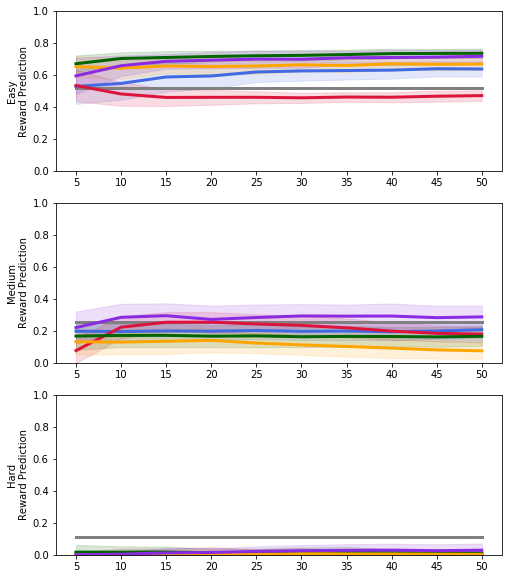

In [14]:
plot_objects(F1[:,0], iterations=iterations, title="Reward Prediction", ylabel="F1 score", ylim=True,
             minimum=0, maximum=1, has_legend=[4], null_data=F1[0,1],)

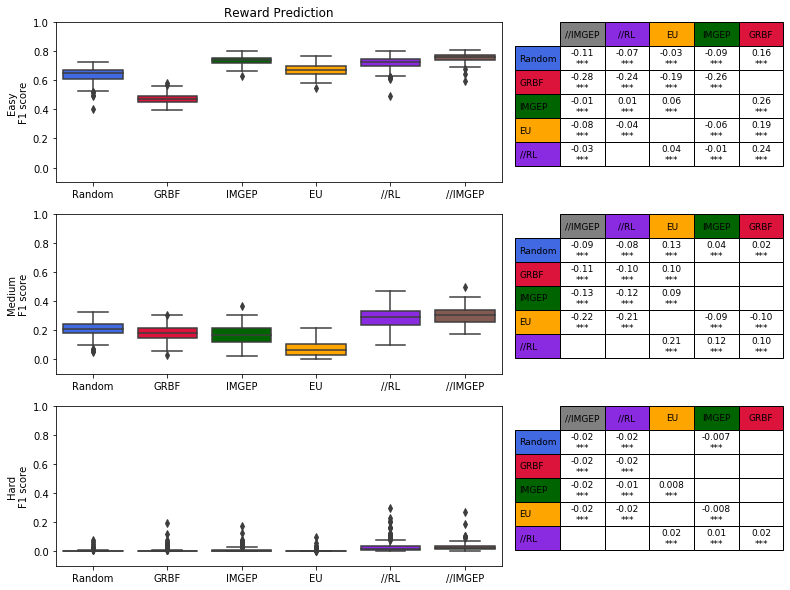

In [216]:
plot_stat(F1[:,0], "Reward Prediction", "F1 score", ylim=(-0.1,1), N=6, Names=Names_6)

## Prediction

In [27]:
null_pred = prediction_errors(None,np.mean, data_type=0, iterations=0)

In [271]:
Traj, Trans, R_traj, R_trans = [], [], [], []

for param in subdirs:
    print(param)
    traj, trans, r_traj, r_trans = prediction_errors(param,np.mean,data_type=data_type,iterations=iterations, n_cpus=cpus, plot=False)
    Traj.append(traj.copy())
    Trans.append(trans.copy())
    R_traj.append(r_traj.copy())
    R_trans.append(r_trans.copy()) 

['/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/random_0', '/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/random_1', '/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/random_2', '/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/random_3', '/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/random_4', '/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/random_5', '/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/random_6', '/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/random_7', '/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/random_8', '/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/random_9']
['/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/grbf_0', '/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/grbf_1', '/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/grbf_2', '/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/grbf_3', '/home/tim/Documents/stage-m2/tf_test/lo

In [272]:
with open("/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/analysis/Trans3.pk", 'wb') as f:
    pickle.dump(Trans, f)
with open("/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/analysis/Traj3.pk", 'wb') as f:
    pickle.dump(Traj, f)
with open("/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/analysis/R_trans3.pk", 'wb') as f:
    pickle.dump(R_trans, f)
with open("/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/analysis/R_traj3.pk", 'wb') as f:
    pickle.dump(R_traj, f)

In [20]:
with open("/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/analysis/Trans3.pk", 'rb') as f:
    Trans = pickle.load(f)
with open("/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/analysis/Traj3.pk", 'rb') as f:
    Traj = pickle.load(f)
with open("/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/analysis/R_trans3.pk", 'rb') as f:
    R_trans = pickle.load(f)
with open("/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/analysis/R_traj3.pk", 'rb') as f:
    R_traj = pickle.load(f)

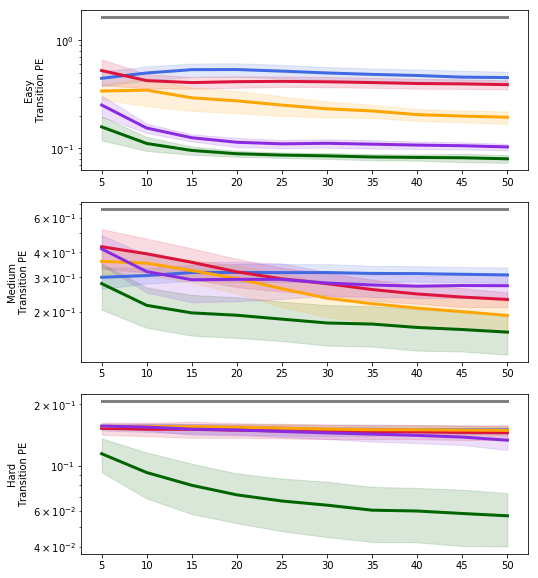

In [28]:
plot_objects(Trans, iterations=iterations, title="Transition PE", ylabel="Error", 
             log = True, null_data=null_pred[1], has_legend=[4])

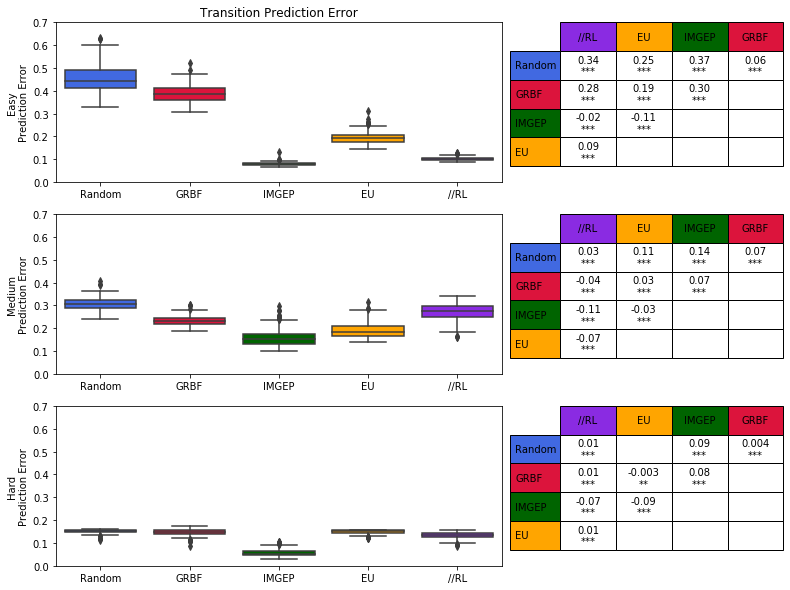

In [163]:
#with open("/home/haretis/Documents/stage-m2/tf_test/log/Evaluation_data/analysis/Trans.pk",'br') as f:
#    trans = pickle.load(f)
plot_stat(Trans, "Transition Prediction Error", "Prediction Error", ylim=(0,0.7), ylog=False)

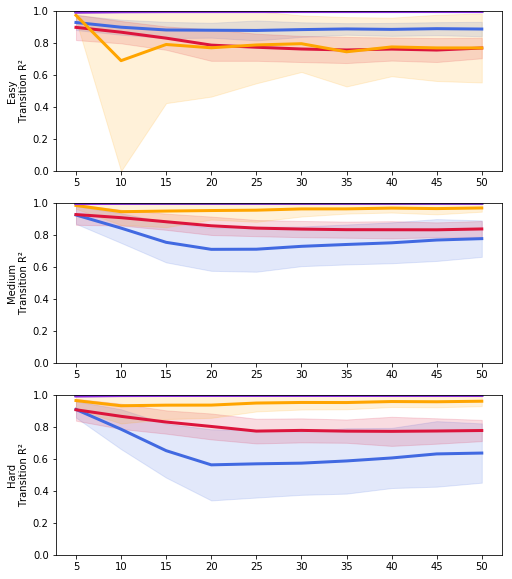

In [90]:
plot_objects(R_trans, iterations=iterations, title="Transition R²", ylabel="R²",has_legend=[3],
             minimum=0, maximum=1, ylim=True)

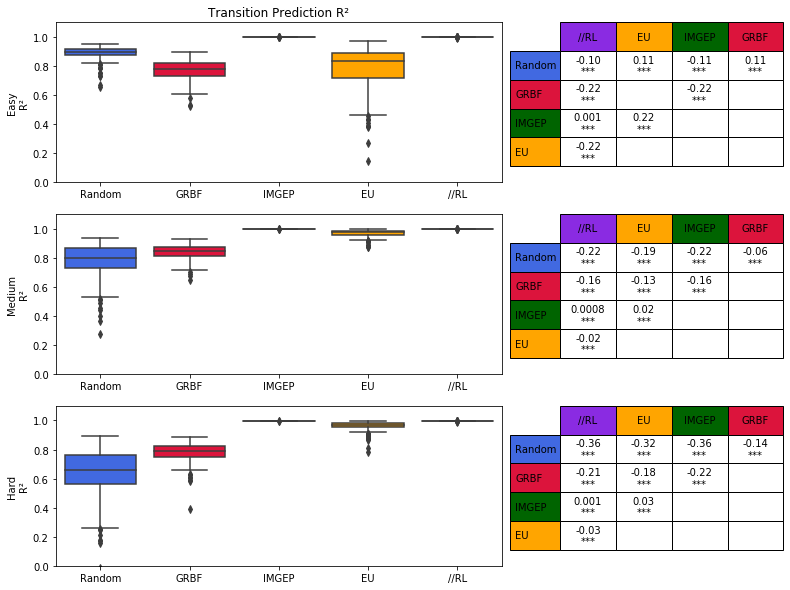

In [165]:
#with open("/home/haretis/Documents/stage-m2/tf_test/log/Evaluation_data/analysis/R_trans.pk",'br') as f:
   # R_trans = pickle.load(f)
plot_stat(R_trans, "Transition Prediction R²", "R²", ylim=(0,1.1))

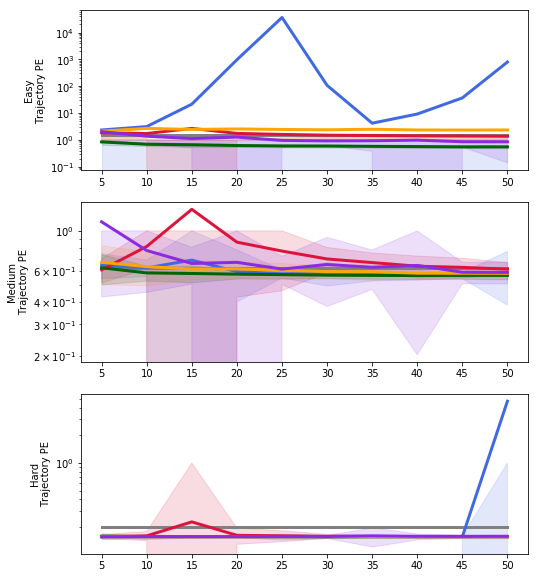

In [92]:
plot_objects(Traj, iterations=iterations, title="Trajectory PE", ylabel="", has_legend=[4],
             minimum=0, maximum=1,null_data=null_pred[0], log=True, ylim=False)

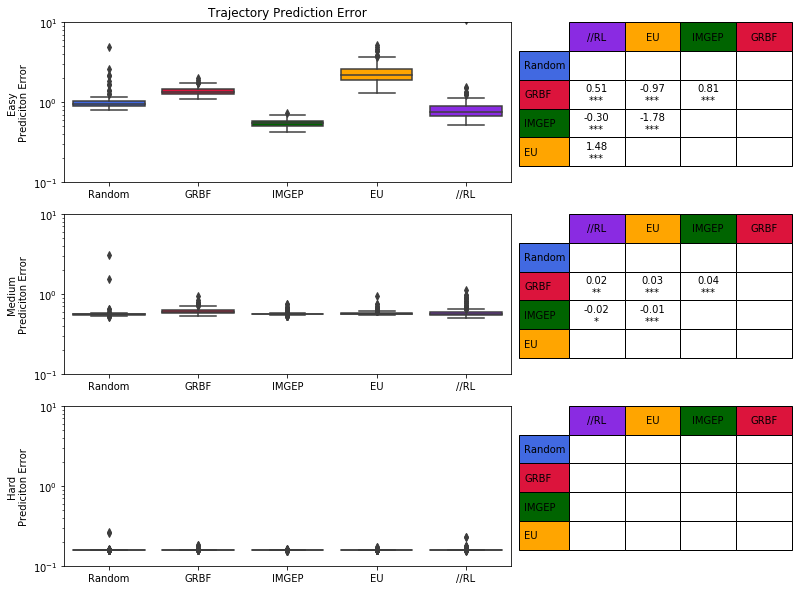

In [169]:
#with open("/home/haretis/Documents/stage-m2/tf_test/log/Evaluation_data/analysis/Traj.pk",'br') as f:
 #   traj = pickle.load(f)
plot_stat(Traj, "Trajectory Prediction Error", "Prediciton Error", ylim=(0.1,10), ylog=True)

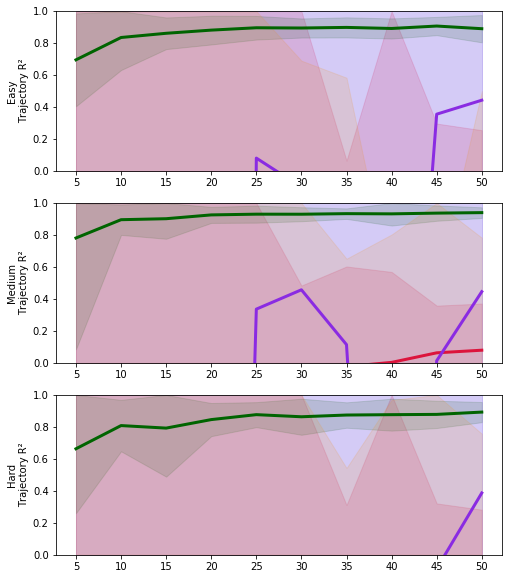

In [94]:
plot_objects(R_traj, iterations=iterations, title="Trajectory R²", ylabel="R²",has_legend=[4],
             minimum=0, maximum=1, ylim=True)

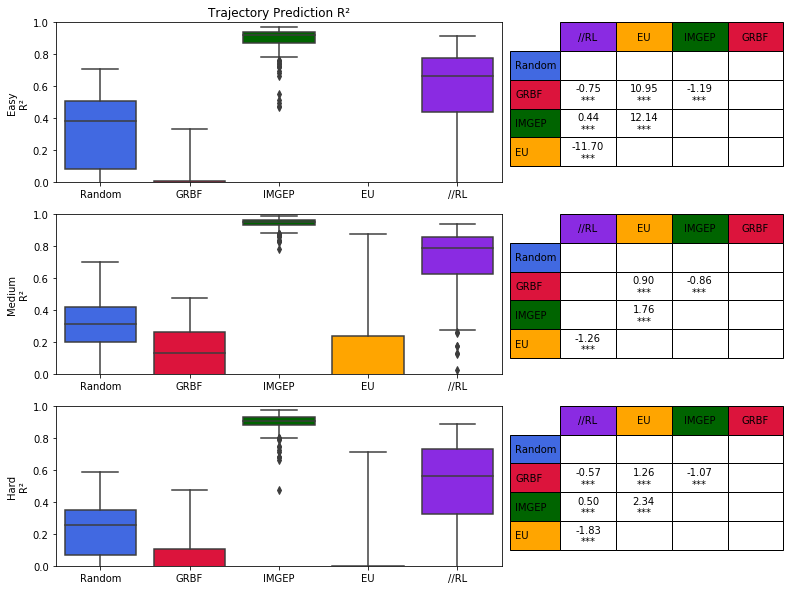

In [173]:
#with open("/home/haretis/Documents/stage-m2/tf_test/log/Evaluation_data/analysis/R_traj.pk",'br') as f:
  #  R_traj = pickle.load(f)
plot_stat(R_traj, "Trajectory Prediction R²", "R²", ylim=(0,1))

## Coverage


In [ ]:
coverage = []
for param in subdirs:
    print(param)
    coverage.append(compute_coverage(param, data_type=data_type, iterations=iterations, n_cpus=cpus, plot=False))

  0%|          | 0/10 [00:00<?, ?it/s]

['/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/random_0', '/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/random_1', '/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/random_2', '/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/random_3', '/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/random_4', '/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/random_5', '/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/random_6', '/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/random_7', '/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/random_8', '/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/random_9']


  0%|          | 0/10 [00:00<?, ?it/s]

['/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/grbf_0', '/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/grbf_1', '/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/grbf_2', '/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/grbf_3', '/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/grbf_4', '/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/grbf_5', '/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/grbf_6', '/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/grbf_7', '/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/grbf_8', '/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/grbf_9']


 70%|███████   | 7/10 [14:39<09:02, 180.78s/it]

In [65]:
with open("/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/analysis/coverage.pk",'bw') as f:
    pickle.dump(coverage, f)

In [69]:
with open("/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/analysis/coverage.pk",'br') as f:
    coverage = np.array(pickle.load( f))

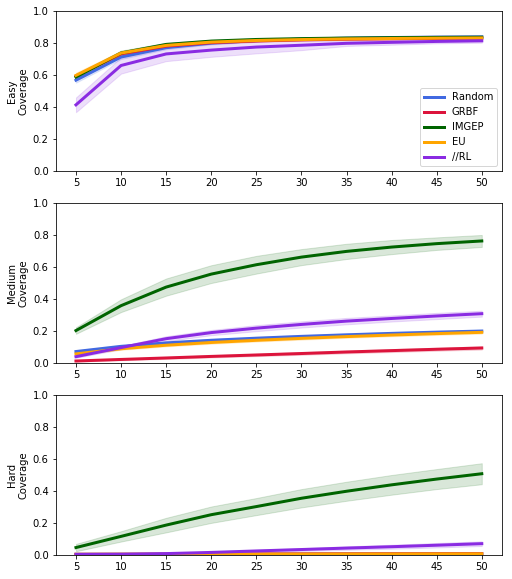

In [70]:
plot_objects(coverage, iterations=iterations, title="Coverage", ylabel="Coverage", minimum=0, maximum=1, ylim=True)

In [316]:
coverage = np.array(coverage)

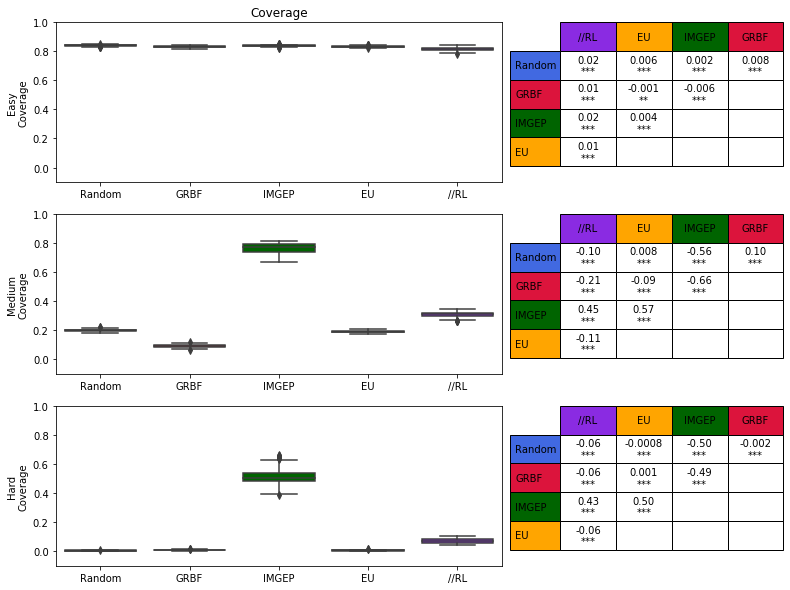

In [174]:
plot_stat(coverage, "Coverage", "Coverage", ylim=(-0.1,1))

## Performance

In [115]:
def plot_objects2(data, iterations, title, ylabel, minimum=0, maximum=np.inf, null_data=None,
                 log =False, ylim=False, has_legend=[0]):
    """ data [params, runs, iterations, objects] """
    fig,ax = plt.subplots(Nobj,1, sharex=True,figsize=(8,10))
    
    if Nobj == 5:
        objects = ['Hand', 'Left Stick','Right Stick', 'Magnet', 'Scratch']
    else:
        objects = ['Easy', 'Medium', 'Hard']
    group_legend = [  obj+"\n"+ title for obj in objects]
    colors = ['royalblue','crimson','darkgreen','orange','blueviolet','grey','black']
    style = ['-','--',':',';']
    
    
    for obj in range(Nobj):
        plt.subplot(Nobj*100+11+obj)
        if not null_data is None:
            plt.plot([1,iterations],[null_data[obj] for _ in range(2)],lw=5, c='grey', label="Null model")
        for i in range(len(data)):
            mean = np.mean(data[i],axis=0)
            std = np.std(data[i], axis=0)
            median = np.median(data[i],axis=0)
            if len(mean) != iterations:
                X = np.array(range(len(mean))) / 10
            else:
                X = range(1,iterations+1)
            color = colors[i]
            for run in range(len(data[i])):
                plt.plot(X, np.array(data[i])[run,:,obj], c=color, lw=2, alpha=0.3)
            mean_p_std = np.minimum(mean[:,obj]+std[:,obj], maximum)
            mean_m_std = np.maximum(mean[:,obj]-std[:,obj], minimum)
            if obj in has_legend:
                plt.plot(X, mean[:,obj], c=color, lw=5, label=Names[i])
            else:
                plt.plot(X, mean[:,obj], c=color, lw=5)
            #plt.plot(X, median[:,obj], c=color, ls='--', lw=5,label=names[i])
            #plt.fill_between(X, mean_p_std, mean_m_std, color=color, alpha=0.15)
            #plt.title(group_legend[obj])
            if obj in has_legend:
                plt.legend()
            if log:
                plt.yscale('log')
            if ylim:
                plt.ylim((0,1))
            plt.ylabel(group_legend[obj])
            if obj == 4:
                plt.xlabel("Training episodes (x10³)")
            s = 1 if len(data) == 5 else 1
            plt.xticks(range(s,11), [str(10*i) for i in range(s,11)])
        name = title
        #plt.savefig("/home/tim/Documents/figs/comparison_data/"+name+".svg", format='svg')

In [233]:
perf = []
for param in perf_subdirs:
    perf.append(compute_performance(param, plot=False, full=False))
perf = np.array(perf)

In [253]:
rematch_perf = []
for param in rematch_perf_subdirs:
    rematch_perf.append(compute_performance(param, plot=False, full=False))
rematch_perf = np.array(rematch_perf)

In [31]:
with open("/home/tim/Documents/stage-m2/tf_test/log/Evaluation_data/analysis/perf.pk",'bw') as f:
    pickle.dump(perf, f)

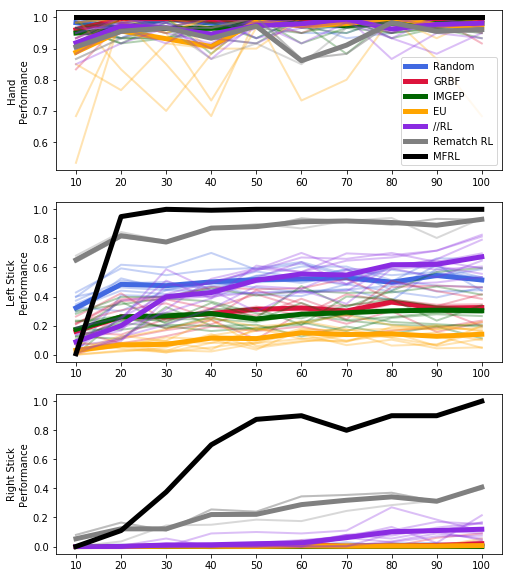

In [42]:
plot_objects2(perf, iterations=iterations, title="Performance", ylabel="Competence", 
              minimum=0, maximum=1, ylim=False, has_legend=[0])

In [220]:
def compute_test(data, coef=1, N=5):
    pairs = []
    for i in range(N-1):
        for j in range(i+1,N):
            pairs.append((i,j))
    res = [[] for _ in range(N)]
    cells = [[[ '' for _ in range(N-1)] for _ in range(N-1)] for _ in range(Nobj)]
    for (param1,param2) in pairs:
        for obj in range(Nobj):
            data1 = np.array(data[param1])[:,-1,obj]
            data2 = np.array(data[param2])[:,-1,obj]
            stat, p_t = ttest_ind(data1,data2)
            p_t = p_t*coef
            d = truncate( np.mean(data1)-np.mean(data2), 2)
            if d=='0.00' or d=='-0.00':
                d = truncate( np.mean(data1)-np.mean(data2), 3)
                if d=='0.000' or d=='-0.000':
                    d = truncate( np.mean(data1)-np.mean(data2), 4)
            if p_t < 0.001:
                res[obj].append((param1, param2, '***'))
                cells[obj][param1][N-1-param2] = d+'\n***'
            elif p_t < 0.01:
                res[obj].append((param1, param2, '**'))
                cells[obj][param1][N-1-param2] = d+'\n**'
            elif p_t < 0.05:
                res[obj].append((param1, param2, '*'))
                cells[obj][param1][N-1-param2] = d+'\n*'
    return res,cells

In [248]:
def plot_stat(Data, title, ylabel, ylim=None, has_legend=[0],bars=False, swarmplot=False, ylog=False, 
              Names=['Random', 'GRBF', 'IMGEP', "EU", "//RL"], N=5,
             colors=['royalblue','crimson','darkgreen','orange','blueviolet','grey'] ):
    """ data [params, runs, iterations, objects] """
    fig,ax = plt.subplots(Nobj,1, sharex=True,figsize=(8,10))
    
    if Nobj == 5:
        objects = ['Hand', 'Left Stick','Right Stick', 'Magnet', 'Scratch']
    else:
        objects = ['Easy', 'Medium', 'Hard']
    
    group_legend = [  obj+"\n"+ ylabel for obj in objects]
    style = ['-','--',':',';']
    stat,cells = compute_test(Data, 3*N*(N-1)/2, N)
    
    for obj in range(Nobj):
        plt.subplot(Nobj*100+11+obj)
        data = [np.array(Data[param])[:,-1,obj] for param in range(N)]
        data_max = np.array([max(np.array(Data[param])[:,-1,obj]) for param in range(N)])
        bplot = sb.boxplot(data=data)
        for i in range(N):
            bplot.artists[i].set_facecolor(colors[i])
        if swarmplot:
            sb.swarmplot( data=data, color='black', edgecolor='black',size=7)
        
        #table
        rows = Names[:N-1]
        columns = [Names[i] for i in range(N-1,0,-1)]
        cell_text = cells[obj]
        the_table = plt.table(cellText=cell_text,
                              rowLabels=rows,
                              rowColours=colors[:N-1],
                              colColours=[ colors[i] for i in range(N-1,0,-1)],
                              colLabels=columns,
                              cellLoc = 'center',
                              bbox=(1.13,0.1,0.5,0.9))

        if bars :
            count = 0
            for (i,j,text) in stat[obj]:
                barplot_annotate_brackets(i, j, text, range(5),data_max+count)
                count += 0.2
        if obj == 0:
            plt.title(title)
        if not ylim is None:
            plt.ylim(ylim)
        if ylog:
            plt.yscale('log')
        plt.xticks(range(N), Names)

        plt.ylabel(group_legend[obj])

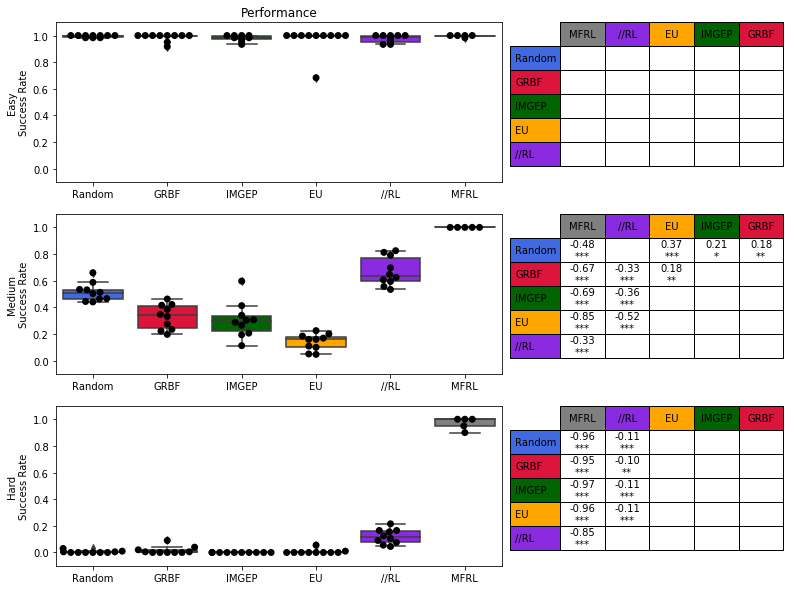

In [243]:
plot_stat(perf, "Performance", "Success Rate", ylim=(-0.1,1.1), swarmplot=True, 
          Names=Names_perf, N=6)

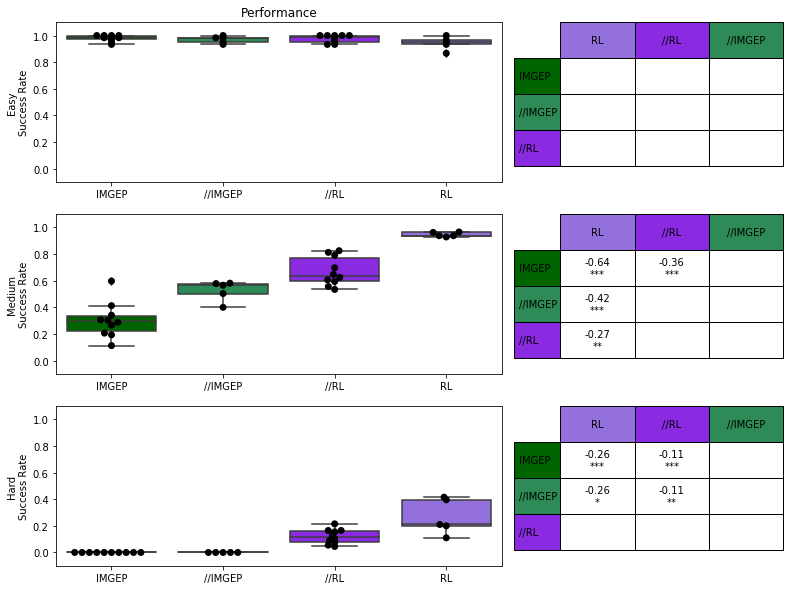

In [254]:
plot_stat(rematch_perf, "Performance", "Success Rate", ylim=(-0.1,1.1), swarmplot=True, 
          Names=Names_rematch_perf , N=4,
          colors=['darkgreen', 'seagreen','blueviolet', 'mediumpurple' ])

In [120]:
def label_diff(i,j,text,X,Y):
    x = (X[i]+X[j])/2
    y = 1.1*max(Y[i], Y[j])
    dx = abs(X[i]-X[j])

    props = {'connectionstyle':'bar','arrowstyle':'-',\
                 'shrinkA':20,'shrinkB':20,'linewidth':2}
    plt.annotate(text, xy=(X[i],y), zorder=10)
    plt.annotate('', xy=(X[i],y), xytext=(X[j],y), arrowprops=props)

In [122]:
def barplot_annotate_brackets(num1, num2, data, center, height, yerr=None, dh=.05, barh=.05, fs=None, maxasterix=None):
    """ 
    Annotate barplot with p-values.

    :param num1: number of left bar to put bracket over
    :param num2: number of right bar to put bracket over
    :param data: string to write or number for generating asterixes
    :param center: centers of all bars (like plt.bar() input)
    :param height: heights of all bars (like plt.bar() input)
    :param yerr: yerrs of all bars (like plt.bar() input)
    :param dh: height offset over bar / bar + yerr in axes coordinates (0 to 1)
    :param barh: bar height in axes coordinates (0 to 1)
    :param fs: font size
    :param maxasterix: maximum number of asterixes to write (for very small p-values)
    """

    if type(data) is str:
        text = data
    else:
        # * is p < 0.05
        # ** is p < 0.005
        # *** is p < 0.0005
        # etc.
        text = ''
        p = .05

        while data < p:
            text += '*'
            p /= 10.

            if maxasterix and len(text) == maxasterix:
                break

        if len(text) == 0:
            text = 'n. s.'

    lx, ly = center[num1], height[num1]
    rx, ry = center[num2], height[num2]

    if yerr:
        ly += yerr[num1]
        ry += yerr[num2]

    ax_y0, ax_y1 = plt.gca().get_ylim()
    dh *= (ax_y1 - ax_y0)
    barh *= (ax_y1 - ax_y0)

    y = max(ly, ry) + dh

    barx = [lx, lx, rx, rx]
    bary = [y, y+barh, y+barh, y]
    mid = ((lx+rx)/2, y+barh)

    plt.plot(barx, bary, c='black')

    kwargs = dict(ha='center', va='bottom')
    if fs is not None:
        kwargs['fontsize'] = fs

    plt.text(*mid, text, **kwargs)

# Corellation

In [221]:
def plot_correlation(data1, data2, log=[0,0]):
    fig,ax = plt.subplots(5,1, sharex=True,figsize=(8,10))
    
    for obj in range(5):
        plt.subplot(511+obj)
        x = []
        y = []
        for param in range(5):
            for run in range(len(data2[param])):
                x.append(data1[param][run][-1][obj])
                y.append(data2[param][run][-1][obj])
        plt.scatter(x,y)
        if log[0] == 1:
            plt.xscale('log')
        elif log[0] == 2:
            plt.xlim((0,1))
        if log[1] == 1:
            plt.yscale('log')
        elif log[1] == 2:
            plt.xlim((0,1))
        print(pearsonr(x,y))

(0.10482048013452405, 0.48317959687544176)
(0.6015510622794666, 7.747467628834095e-06)
(0.4583292193703404, 0.001196125292527095)
(0.07250864461456356, 0.6281395991622024)
(0.20056721540882985, 0.17644707819797784)


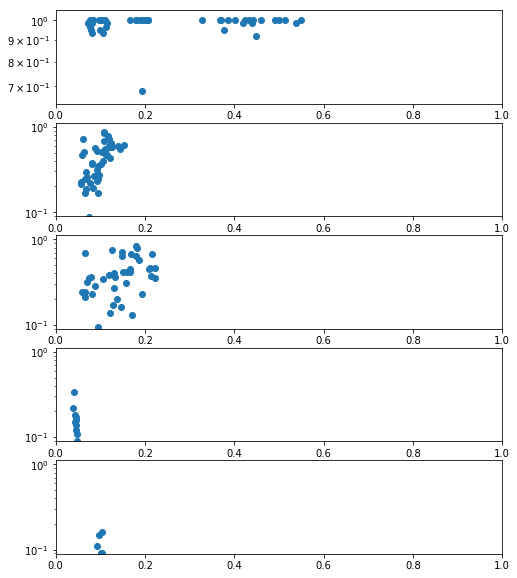

In [225]:
plot_correlation(Trans, perf,  [2,1])

In [97]:
def truncate(f, n):
    '''Truncates/pads a float f to n decimal places without rounding'''
    s = '{}'.format(f)
    if 'e' in s or 'E' in s:
        return '{0:.{1}f}'.format(f, n)
    i, p, d = s.partition('.')
    return '.'.join([i, (d+'0'*n)[:n]])

In [34]:
def compute_rank(data, perf=False, reverse=False):
    if perf:
        rk_data = [[] for _ in range(5)]
        l0,l1,l2 = [],[],[]
        for param in range(5):
                l0 += list(np.array(data[param])[:,-1,0])
                l1 += list(np.array(data[param])[:,-1,1])
                l2 += list(np.array(data[param])[:,-1,2])
            
        l0.sort()
        l1.sort()
        l2.sort()
        if reverse:
            l0.reverse()
            l1.reverse()
            l2.reverse()
        for param in range(5):
            for run in range(len(data[param])):
                r0, r1, r2 = [], [], []
                r0.append(l0.index(np.array(data[param])[run][-1][0]))
                r1.append(l1.index(np.array(data[param])[run][-1][1]))
                r2.append(l2.index(np.array(data[param])[run][-1][2]))
                rk_data[param].append(np.mean([r0,r1,r2]))
    else:
        rk_data = [[] for _ in range(5)]
        l0,l1,l2 = [],[],[]
        for param in range(5):
            for run in range(len(data[param])//20):
                l0 += list(data[param][20*run:20*(run+1),-1,0])
                l1 += list(data[param][20*run:20*(run+1),-1,1])
                l2 += list(data[param][20*run:20*(run+1),-1,2])
        l0.sort()
        l1.sort()
        l2.sort()
        if reverse:
            l0.reverse()
            l1.reverse()
            l2.reverse()
        for param in range(5):
            for run in range(len(data[param])//20):
                r0, r1, r2 = [], [], []
                for i in range(20):
                    r0.append(l0.index(data[param][20*run+i][-1][0]))
                    r1.append(l1.index(data[param][20*run+i][-1][1]))
                    r2.append(l2.index(data[param][20*run+i][-1][2]))
                rk_data[param].append(np.mean([r0,r1,r2]))
    return rk_data

In [74]:
def compute_correlation(coef=1):
    data = [compute_rank(Trans, reverse=True), compute_rank(R_trans),
            compute_rank(Traj,reverse=True), compute_rank(R_traj),
            compute_rank(F1[:,0]), compute_rank(coverage),  compute_rank(perf,True)]
    pairs = [(0,1),(0,2),(0,3),(0,4),(0,5),(0,6),
             (1,2),(1,3),(1,4),(1,5),(1,6),
             (2,3),(2,4),(2,5),(2,6),
             (3,4),(3,5),(3,6),
             (4,5),(4,6),
             (5,6)]
    cells = [[ '' for _ in range(6)] for _ in range(6)] 
    res2 = []
    for (i,j) in pairs:
        data1, data2 = data[i], data[j]
        x = []
        y = []
        for param in range(5):
            for run in range(len(data2[param])):
                x.append(data1[param][run])
                y.append(data2[param][run])
        (corr, p) = pearsonr(x,y)
        p = p*coef
        if p < 0.001:
            cells[i][5-(j-1)] = truncate(corr,2)+'\n ***'
        elif p < 0.01:
            cells[i][5-(j-1)] = truncate(corr,2)+'\n **'
        elif p < 0.05:
            cells[i][5-(j-1)] = truncate(corr,2)+'\n *'
    return cells

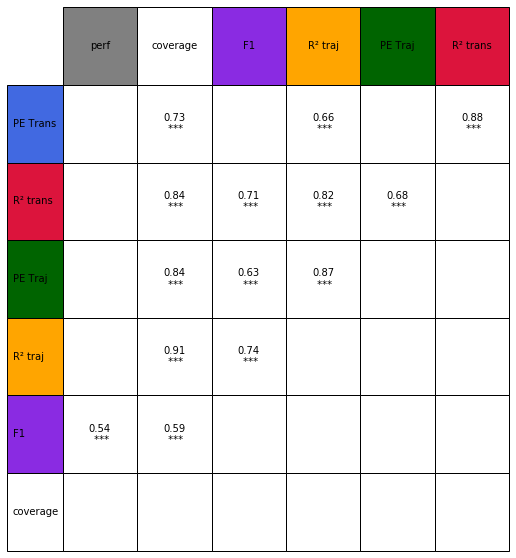

In [82]:
def plot_full():
    fig,ax = plt.subplots(1, sharex=True,figsize=(8,10))

    colors = ['royalblue','crimson','darkgreen','orange','blueviolet','white','grey']
    names = ['PE Trans', 'R² trans', 'PE Traj', 'R² traj',  "F1", 'coverage', "perf"]
    rows = names[:-1]
    columns = [names[i] for i in [6,5,4,3,2,1]]
    cell_text = compute_correlation(21)
    the_table = plt.table(cellText=cell_text,
                          rowLabels=rows,
                          rowColours=colors[:6],
                          colColours=[ colors[i] for i in [6,5,4,3,2,1]],
                          colLabels=columns,
                          cellLoc = 'center',
                          bbox=(0,0,1,1))
    ax.axis('off')
    ax.set_yticklabels([])
    ax.set_xticklabels([])
plot_full()

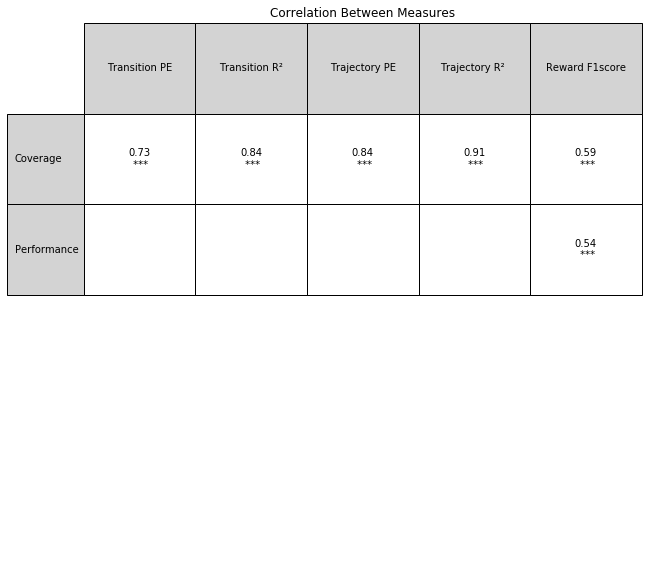

In [177]:
def plot_reduced():
    fig,ax = plt.subplots(1, sharex=True,figsize=(10,10))

    colors = ['royalblue','crimson','darkgreen','orange','blueviolet','grey','cyan']

    columns = ['Transition PE',  'Transition R²', 'Trajectory PE','Trajectory R² ',"Reward F1score"]
    colColours = ['lightgrey','lightgrey','lightgrey','lightgrey','lightgrey']
    
    rows = ['Coverage','Performance']
    rowColours = ['lightgrey','lightgrey']
    cells = compute_correlation(5)
    cell_text = [[cells[i][1-j] for i in range(5)] for j in range(2)]    
    the_table = plt.table(cellText=cell_text,
                          rowLabels=rows,
                          rowColours=rowColours,
                          colColours=colColours,
                          colLabels=columns,
                          cellLoc = 'center',
                          bbox=(0,0.5,1,0.5))
    ax.axis('off')
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    plt.title("Correlation Between Measures")
    
plot_reduced()